<a href="https://colab.research.google.com/github/hws2002/Deep_Learning_with_Keras/blob/main/Chapte9/Chapter9_3_arhcitecture_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모듈화, 계층화 그리고 재사용

# 잔차 연결

필터 개수가 변경되는 잔차 블록 ( 잔차 연결이 적용된 블록을 잔차 블록이라고 부름)

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape = (32,32,3))
x = layers.Conv2D(32, 3, activation = "relu")(inputs)

residual = x # 잔차를 따로 저장함

x = layers.Conv2D(64, 3, activation = "relu", padding = "same")(x)

residual = layers.Conv2D(64,1)(residual)
x = layers.add([x, residual]) # 이제 블록 출력과 잔차의 크기가 같으므로 더할 수 있음.

최대 풀링 층을 가진 잔차 블록

In [8]:
inputs = keras.Input(shape = (32,32,3))
x = layers.Conv2D(32, 3, activation = "relu")(inputs)
residual = x # 잔차를 따로 저장함
x = layers.Conv2D(64, 3, activation ="relu", padding = "same")(x)
x = layers.MaxPooling2D(2, padding = "same")(x)
residual = layers.Conv2D(64, 1, strides = 2)(residual)
x = layers.add([x, residual])

In [ ]:
inputs = keras.Input(shape = (32,32,3))
x = layers.Rescaling(1./255)(inputs)

def residual_block(x, filters, pooling=False):
  residual = x
  x = layers.Conv2D(filters, 3, activation = "relu", padding = "same")(x)
  x = layers.Conv2D(filters, 3, activation = "relu", padding = "same")(x)

  if pooling :
    x = layers.MaxPooling2D(2, padding = "same")(x)
    residual = layers.Conv2D(filters, 1, strides = 2)(residual)
  elif filters != residual.shape[-1]:
    residual = layers.Conv2D(filters, 1)(residual)
  x = layers.add([x, residual])
  return x


x = residual_block(x, filters = 32, pooling = True)
x = residual_block(x, filters = 64, pooling = True)
x = residual_block(x, filters = 128, pooling = False)

x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs = inputs, outputs = outputs)
model.summary()

# 배치 정규화

# Xception 유사 모델

In [9]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

In [26]:
inputs = keras.Input(shape = (180,180,3))

x = data_augmentation(inputs) # 데이터 증식 설정은 이전과 동일
x = layers.Rescaling(1./255)(x) # 입력 데이터의 스케일 조정
x = layers.Conv2D(filters = 32, kernel_size = 5, use_bias = False)(x)
# 보통 RGB 이미지의 특성 채널은 독립적이지 않으므로, 첫 번째 층은 일반적인 Conv2D이고,
# 그 다음부터 SeparableConv2D를 사용가능함


for size in [32, 64, 128, 256, 512]:
  '''
  특성 맵 깊이를 증가시키면서 합성곱 블록을 연속적으로 적용.
  각 블록은 배치 정규화 층을 적용한 2개의 깊이별 분리 합성곱 층와 하나의 최대 풀링 층으로 구성됨.
  블록마다 잔차 연결이 추가됨.
  '''
  residual = x

  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding = "same", use_bias = False)(x)

  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding = "same", use_bias = False)(x)

  x = layers.MaxPooling2D(3, strides = 2, padding  ="same")(x)

  residual = layers.Conv2D(
      size, 1, strides = 2, padding="same", use_bias = False)(residual)
  x = layers.add([x,residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs = inputs, outputs = outputs)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 180, 180, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 180, 180, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 180, 180, 3)    │              0 │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 176, 176, 32)   │          2,400 │ rescaling_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 176, 176, 32)   │            128 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 176, 176, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_10       │ (None, 176, 176, 32)   │          1,312 │ activation_10[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 176, 176, 32)   │            128 │ separable_conv2d_10[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_11             │ (None, 176, 176, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_11       │ (None, 176, 176, 32)   │          1,312 │ activation_11[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 88, 88, 32)     │              0 │ separable_conv2d_11[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 88, 88, 32)     │          1,024 │ conv2d_18[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_7 (Add)               │ (None, 88, 88, 32)     │              0 │ max_pooling2d_8[0][0], │
│                           │                        │                │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 88, 88, 32)     │            128 │ add_7[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_12        

 Total params: 721,857 (2.75 MB)

 Trainable params: 718,849 (2.74 MB)

 Non-trainable params: 3,008 (11.75 KB)

모델을 훈련해보자

## 데이터 가져오기 (8.2)

In [ ]:
# 8.2에서 가져올것들
# train, validation, test dataset
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/Colab\ Notebooks/DEEP_LEARNING_KERAS/Chapter8/train.zip -d /content/

import os, shutil, pathlib
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")
def make_subset(subset_name, start_index, end_index):

  for category in ('cat', 'dog'):
    dir = new_base_dir / subset_name / category

    if dir.exists(): # 이미 해당 파일이 존재한다면 삭제한다 (덮어씌우기)
      shutil.rmtree(dir)

    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg"
             for i in range(start_index, end_index)]

    for fname in fnames:
      shutil.copyfile(src = original_dir / fname,
                      dst = dir / fname)


make_subset("train",0,1000)
make_subset("validation",1000,1500)
make_subset("test",1500,2500)


In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size = (180,180),
    batch_size = 32
)

validation_dataset = image_dataset_from_directory(
    new_base_dir / 'validation',
    image_size = (180,180),
    batch_size = 32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size = (180,180),
    batch_size = 32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [27]:
model.compile(
    optimizer = "rmsprop",
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint( # 매 에포크 끝에서 현재 가중치를 저장함
        filepath = "Xception_from_scratch.keras",
        save_best_only = True,
        monitor = "val_loss"
    )
]

history = model.fit(
    train_dataset,
    epochs = 100,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.5169 - loss: 0.7767 - val_accuracy: 0.5050 - val_loss: 0.6932
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 214ms/step - accuracy: 0.5948 - loss: 0.6731 - val_accuracy: 0.5060 - val_loss: 0.6929
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - accuracy: 0.6133 - loss: 0.6526 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.6263 - loss: 0.6359 - val_accuracy: 0.5000 - val_loss: 0.6973
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.6772 - loss: 0.6243 - val_accuracy: 0.5000 - val_loss: 0.7222
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.6726 - loss: 0.5979 - val_accuracy: 0.5000 - val_loss: 0.8362
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.6995 - loss: 0.5869 - val_accuracy: 0.5000 - val_loss: 0.8890
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.6956 - loss: 0.5859 - 

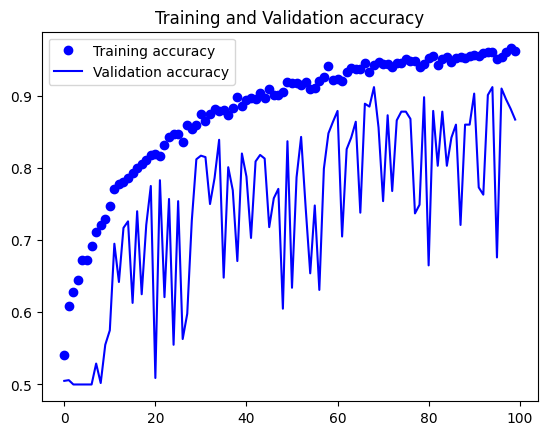

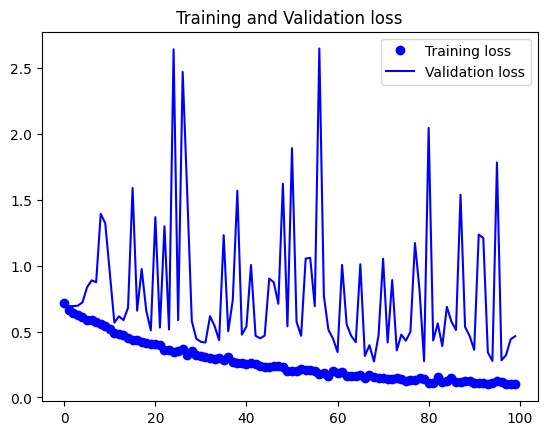

In [35]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(val_acc) + 1)

plt.plot(train_acc, 'bo', label = "Training accuracy")
plt.plot(val_acc, 'b', label = "Validation accuracy")
plt.title("Training and Validation accuracy")
plt.xticks(range(0,101,20))


plt.legend()
plt.show()

plt.plot(train_loss, 'bo', label = "Training loss")
plt.plot(val_loss, 'b', label = "Validation loss")
plt.title("Training and Validation loss")
plt.xticks(range(0,101,20))
plt.legend()
plt.show()

In [36]:
test_loss, test_acc = model.evaluate(test_dataset)
print(test_loss, test_acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8774 - loss: 0.4867
0.5095557570457458 0.8669999837875366
